# decross dataset model

이번 아이디어는 고정이의 제안을 받아들여, 데이터가 겹치지 않도록 축소시켜서 학습하는 모델입니다.

기존에는 t ~ t+n 을 학습시키고, t+n+1 을 예측한 후 <br>
다음 row에서 t+1 ~ t+n+1 을 학습시키고, t+n+2 를 예측했습니다.

즉 첫 행의 y^ 값이 다음 행의 학습 데이터로 들어갑니다.

본 모델은 이러한 데이터가 겹치는 현상을 방지하기 위해 다음과 같이 짭니다.

t ~ t+n -> t+n+1<br>
t+n+2 ~ t+2n+2 -> t+2n+3

데이터 수가 줄어드는 것이 단점입니다. 일단 돌려보죠.

In [170]:
# load_dtypes()
# DF 불러올 때부터 축소해서 가져오는 함수.

def load_dtypes(file_path):
    print(file_path)
    tmp = pd.read_csv(file_path, nrows=0) # 애초에 파일을 불러올 때
    col_dtypes= {}
    for col in tmp.columns:
        df = pd.read_csv(file_path, usecols=[col]) # 애초에 파일을 불러올 때
        
        dtype = df[col].dtype
        
        if (dtype == 'int8' or dtype == 'int16' or dtype == 'int32' or dtype == 'int64'):
            c_min = df[col].min()
            c_max = df[col].max()
            dtype = 'int'
            
        elif dtype == 'float32' or dtype == 'float64':
            c_min = df[col].min()
            c_max = df[col].max()
            dtype = 'float'
            
        elif dtype == 'object':
            n_unique = df[col].nunique()
            threshold = n_unique / df.shape[0]
            
        if dtype == 'int':
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                col_dtype = 'int8'
            elif c_min > np.iinfo(np.uint8).min and c_max < np.iinfo(np.uint8).max:
                col_dtype = 'uint8'
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                col_dtype = 'int16'
            elif c_min > np.iinfo(np.uint16).min and c_max < np.iinfo(np.uint16).max:
                col_dtype = 'uint16'
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                col_dtype = 'int32'
            elif c_min > np.iinfo(np.uint32).min and c_max < np.iinfo(np.uint32).max:
                col_dtype = 'uint32'
            elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                col_dtype = 'int64'
            elif c_min > np.iinfo(np.uint64).min and c_max < np.iinfo(np.uint64).max:
                col_dtype = 'uint64'
                
        elif dtype == 'float':
            if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                col_dtype = 'float32'
            else:
                col_dtype = 'float64'
                
        elif dtype == 'object':
            if threshold > 0.7:
                col_dtype = 'object'
            else:
                col_dtype = 'category'
                
        col_dtypes[col] = col_dtype
        

    df = pd.read_csv(file_path, dtype=col_dtypes)
    
    return df

In [171]:
import pandas as pd
import numpy as np
import os, sys
import glob
import random
import math
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt
import seaborn as sns

In [281]:
TRAIN_PATH = r'C:\Users\Wyatt\wyatt37\Data\solarpanel\train\train.csv'
TEST_PATH = r'C:\Users\Wyatt\wyatt37\Data\solarpanel\test'
SUBMISSION_PATH = r'C:\Users\Wyatt\wyatt37\Data\solarpanel\sample_submission.csv'

In [282]:
train = load_dtypes(TRAIN_PATH)
train.info()

C:\Users\Wyatt\wyatt37\Data\solarpanel\train\train.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52560 entries, 0 to 52559
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Day     52560 non-null  int16  
 1   Hour    52560 non-null  int8   
 2   Minute  52560 non-null  int8   
 3   DHI     52560 non-null  int16  
 4   DNI     52560 non-null  int16  
 5   WS      52560 non-null  float32
 6   RH      52560 non-null  float32
 7   T       52560 non-null  int8   
 8   TARGET  52560 non-null  float32
dtypes: float32(3), int16(3), int8(3)
memory usage: 1.1 MB


In [283]:
submission = pd.read_csv(SUBMISSION_PATH)

In [284]:
train

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
0,0,0,0,0,0,1.5,69.080002,-12,0.0
1,0,0,30,0,0,1.5,69.059998,-12,0.0
2,0,1,0,0,0,1.6,71.779999,-12,0.0
3,0,1,30,0,0,1.6,71.750000,-12,0.0
4,0,2,0,0,0,1.6,75.199997,-12,0.0
...,...,...,...,...,...,...,...,...,...
52555,1094,21,30,0,0,2.4,70.699997,-4,0.0
52556,1094,22,0,0,0,2.4,66.790001,-4,0.0
52557,1094,22,30,0,0,2.2,66.779999,-4,0.0
52558,1094,23,0,0,0,2.1,67.720001,-4,0.0


## 이전 버전들의 파생변수 생성 함수

In [285]:
def sum_hour_minute(train):
    # 0과 30으로 되어 있는 minute을 0과 0.5로 바꿉니다.
    train.Minute = round(train.Minute * 0.017, 1)
    # hour에 minute을 더해줍니다.
    train.Hour = train.Hour + train.Minute
    
    return train

In [286]:
# DHI의 값에 따라서 0~180의 값을 가지는 정규화 함수입니다.

def angle_normalizor(list_, lags=48):
    min_ = min(list_)
    max_ = max(list_)
    return ((list_ - min_) / (max_ - min_))*180

In [287]:
# 천정각에 의해 GHI를 출력하는 함수입니다.

def ghi_formula(DHI, DNI, theta):
    return (DHI + (DNI*np.cos((np.abs(theta-90)-1)*0.0174533)))

In [288]:
# 하루 단위로(48개 index) DHI에 따른 천정각으로 GHI를 만들어주는 함수입니다.

def make_GHI(train, start_window=0, window=48):
    
    end_window = train.shape[0] / window
    #stride = window
    DHI = train.DHI # DHI value 값을 받습니다.
    DNI = train.DNI # DNI value 값을 받습니다.
    GHI = []
    
    #for i in tqdm(range(3)): # 테스트용 코드
    for i in range(np.int(end_window)):
        #print(i)
        if i == 0:
            #print(start_window)
            dhi_window = DHI[start_window:window] # 0부터 window=48 까지를 슬라이싱 해서 받습니다.
            dni_window = DNI[start_window:window]
            # 정규화 시키고,
            dhi_normal = angle_normalizor(dhi_window)
            # GHI 만들고
            new_GHI = ghi_formula(dhi_window, dni_window, dhi_normal)
            # 리스트에 더해줍니다.
            GHI = GHI + list(new_GHI)
        else:
            #print(window)
            dhi_window = DHI[(window*i):(window*(i+1))] # window*i 부터 window*(i+1) 까지를 슬라이싱
            dni_window = DNI[(window*i):(window*(i+1))]
            # 정규화 시키고,
            dhi_normal = angle_normalizor(dhi_window)
            # GHI 만들고
            new_GHI = ghi_formula(dhi_window, dni_window, dhi_normal)
            # 리스트에 더해줍니다.
            GHI = GHI + list(new_GHI)

            #window += stride # 윈도우를 옆으로 stride 시켜준다.
            
            
    train['GHI'] = GHI
    return train

In [289]:
# 시간에 따른 천정각 추가 함수
def time_sun_angle(train):
    
    one_radial = 6.17
    renew_radial = 0
    angle = []

    for i in range(48):
        if (i/2) > 19.1:
            angle.append(1)

        elif (i/2) > 4.9:
            renew_radial += one_radial
            angle.append(renew_radial)
        else:
            angle.append(1)

        i += 0.5
        
    train['ANGLE'] = angle*(int(train.shape[0]/48))
    
    return train

In [290]:
# sun_angle 에 따른 GHI 만드는 함수
def sun_angle_ghi(train):
    train['NEW_GHI'] = train['DHI'] + (train['DNI']*(np.cos((train['ANGLE'] - 90)*0.0174533)))
    
    return train

In [291]:
# 총 일사량 만들기
def total_irradiance(train):
    train['TA'] = train.DHI + train.DNI
    
    return train

In [292]:
# 파생변수 만드는 함수
def make_features(train):
    print("original_shape: ", train.shape)
    # hour와 minute 합쳐줍니다.
    train = sum_hour_minute(train)
    
    #-------------------- 파생변수 생성하면 이 아래에 추가
    new_train = make_GHI(train, start_window=0, window=48)
    # 일단 sun_angle을 만듭니다.
    new_train = time_sun_angle(new_train)
    # new_ghi 만듭니다.
    new_train = sun_angle_ghi(new_train)
    # total irradiance 만듭니다.
    new_train = total_irradiance(new_train)
    
    # 필요 없는 column 을 지워줍니다.
    new_train.drop(['Day', 'Minute', 'ANGLE'], axis=1, inplace=True)  
    
    print("feature_creationed: ", new_train.shape)
    
    return new_train

In [293]:
train = make_features(train)

original_shape:  (52560, 9)
feature_creationed:  (52560, 10)


In [294]:
train

,Hour,DHI,DNI,WS,RH,T,TARGET,GHI,NEW_GHI,TA
0,0.0,0,0,1.5,69.080002,-12,0.0,0.0,0.0,0
1,0.5,0,0,1.5,69.059998,-12,0.0,0.0,0.0,0
2,1.0,0,0,1.6,71.779999,-12,0.0,0.0,0.0,0
3,1.5,0,0,1.6,71.750000,-12,0.0,0.0,0.0,0
4,2.0,0,0,1.6,75.199997,-12,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...
52555,21.5,0,0,2.4,70.699997,-4,0.0,0.0,0.0,0
52556,22.0,0,0,2.4,66.790001,-4,0.0,0.0,0.0,0
52557,22.5,0,0,2.2,66.779999,-4,0.0,0.0,0.0,0
52558,23.0,0,0,2.1,67.720001,-4,0.0,0.0,0.0,0


## decross shifted model 함수

In [295]:
def shift_columns(data, shifted_columns, lags):
    
    temp = data.copy()
    for lag in lags:
        for col in shifted_columns:
            temp[col + '_lag_%s'%lag] = temp[col].shift(lag)
            # lag model 과 -lag model 의 치명적인 차이 발견
            # lag model 은 아래로 shift를 시키기 때문에 기준이 최신날짜가 됨
            # 즉, 데이터는 t ~ t-n 이고, 타겟은 t+1, t+2 가 됨. 즉 겹치지 않음.
            # -lag model은 위로 shift 하기 때문에 기준은 시작 날짜가 됨.
            # 즉 , 데이터는 t ~ t+n 이고, 타겟은 t+1, t+2 가 됨. 즉 학습 데이터 안에 정보가 있음.
            
            # 테스트 데이터는 t ~ t-n 의 데이터를 가지고 t+1, t+2를 예측해야 함.
            # 즉, 학습과 예측을 동일하게 맞추려면 lag model로 가야함.
            # 근데 문제는 성능은 -lag model이 더 잘나온다는 거.
            
    return temp

In [296]:
# 하루 단위로 시프트를 하고, dropna를 하고 다시 합치는 함수를 만들어야 합니다.

def shift_daybyday(train, shifted_columns, lags, period=432):
    
    df = []
    window=0 # 초기값 셋팅
    period = period # 짜를 단위 셋팅(9일, train 7일, target 2일)
    end_window = train.shape[0] / period
    #print(end_window)
    
    #for i in range(3):
    for i in range(np.int(end_window)):
        # 하루 단위로 찢습니다.
        temp = train[window:window+period]
        # 시프트 해줍니다.
        temp = shift_columns(temp, shifted_columns, lags)[:period-96]
        # 나머지 날려주고요.
        temp = temp.dropna()
        # 더해줍니다.
        df.append(temp)
        # 윈도우 값 리셋팅
        window += period
        #print(window)
        #print(temp.shape)

    new_train = pd.concat(df)
    print(new_train.shape)
    
    return new_train


In [298]:
# 타겟값을 미리 만들어줘야 합니다.
train['TARGET_1'] = train.TARGET.shift(48)
train['TARGET_2'] = train.TARGET_1.shift(48)

In [299]:
train

,Hour,DHI,DNI,WS,RH,T,TARGET,GHI,NEW_GHI,TA,TARGET_1,TARGET_2
0,0.0,0,0,1.5,69.080002,-12,0.0,0.0,0.0,0,NaN,NaN
1,0.5,0,0,1.5,69.059998,-12,0.0,0.0,0.0,0,NaN,NaN
2,1.0,0,0,1.6,71.779999,-12,0.0,0.0,0.0,0,NaN,NaN
3,1.5,0,0,1.6,71.750000,-12,0.0,0.0,0.0,0,NaN,NaN
4,2.0,0,0,1.6,75.199997,-12,0.0,0.0,0.0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
52555,21.5,0,0,2.4,70.699997,-4,0.0,0.0,0.0,0,0.0,0.0
52556,22.0,0,0,2.4,66.790001,-4,0.0,0.0,0.0,0,0.0,0.0
52557,22.5,0,0,2.2,66.779999,-4,0.0,0.0,0.0,0,0.0,0.0
52558,23.0,0,0,2.1,67.720001,-4,0.0,0.0,0.0,0,0.0,0.0


In [321]:
shifted_columns = ['DHI', 'DNI', 'WS', 'RH', 'T', 'TARGET', 'GHI', 'NEW_GHI', 'TA']
lags = [48, 96, 144]

new_train = shift_daybyday(train, shifted_columns, lags, 288)

(8736, 39)


In [322]:
X = new_train[:6000]
val = new_train[6000:]

In [323]:
def make_train_test_val(X, val, features):

    x_train = X[features]
    y_train_1 = X['TARGET_1']
    y_train_2 = X['TARGET_2']

    x_val = val[features]
    y_val_1 = val['TARGET_1']
    y_val_2 = val['TARGET_2']
    
    print(x_train.shape)
    
    return x_train, y_train_1, y_train_2, x_val, y_val_1, y_val_2

In [324]:
X.columns

Index(['Hour', 'DHI', 'DNI', 'WS', 'RH', 'T', 'TARGET', 'GHI', 'NEW_GHI', 'TA',
       'TARGET_1', 'TARGET_2', 'DHI_lag_48', 'DNI_lag_48', 'WS_lag_48',
       'RH_lag_48', 'T_lag_48', 'TARGET_lag_48', 'GHI_lag_48',
       'NEW_GHI_lag_48', 'TA_lag_48', 'DHI_lag_96', 'DNI_lag_96', 'WS_lag_96',
       'RH_lag_96', 'T_lag_96', 'TARGET_lag_96', 'GHI_lag_96',
       'NEW_GHI_lag_96', 'TA_lag_96', 'DHI_lag_144', 'DNI_lag_144',
       'WS_lag_144', 'RH_lag_144', 'T_lag_144', 'TARGET_lag_144',
       'GHI_lag_144', 'NEW_GHI_lag_144', 'TA_lag_144'],
      dtype='object')

In [325]:
features = ['Hour', 'DHI', 'DNI', 'WS', 'RH', 'T', 'TARGET', 'GHI',
       'NEW_GHI', 'TA', 'DHI_lag_48', 'DNI_lag_48',
       'WS_lag_48', 'RH_lag_48', 'T_lag_48', 'TARGET_lag_48', 'GHI_lag_48',
       'NEW_GHI_lag_48', 'TA_lag_48', 'DHI_lag_96', 'DNI_lag_96', 'WS_lag_96',
       'RH_lag_96', 'T_lag_96', 'TARGET_lag_96', 'GHI_lag_96',
       'NEW_GHI_lag_96', 'TA_lag_96', 'DHI_lag_144', 'DNI_lag_144',
       'WS_lag_144', 'RH_lag_144', 'T_lag_144', 'TARGET_lag_144',
       'GHI_lag_144', 'NEW_GHI_lag_144', 'TA_lag_144']
            
#             , 'DHI_lag_144', 'DNI_lag_144',
#        'WS_lag_144', 'RH_lag_144', 'T_lag_144', 'TARGET_lag_144',
#        'GHI_lag_144', 'NEW_GHI_lag_144', 'TA_lag_144', 'DHI_lag_192',
#        'DNI_lag_192', 'WS_lag_192', 'RH_lag_192', 'T_lag_192',
#        'TARGET_lag_192', 'GHI_lag_192', 'NEW_GHI_lag_192', 'TA_lag_192',
#        'DHI_lag_240', 'DNI_lag_240', 'WS_lag_240', 'RH_lag_240', 'T_lag_240',
#        'TARGET_lag_240', 'GHI_lag_240', 'NEW_GHI_lag_240', 'TA_lag_240',
#        'DHI_lag_288', 'DNI_lag_288', 'WS_lag_288', 'RH_lag_288', 'T_lag_288',
#        'TARGET_lag_288', 'GHI_lag_288', 'NEW_GHI_lag_288', 'TA_lag_288']

In [326]:
x_train, y_train_1, y_train_2, x_val, y_val_1, y_val_2 = make_train_test_val(X, val, features)

(6000, 37)


## 테스트 파일 로드

In [331]:
class HiddenPrints: # print를 막아주는 클래스 입니다.
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

        # test set load
with HiddenPrints():
    df_test = []

    for i in range(81):
        file_path = TEST_PATH + '/' + str(i) + '.csv'
        temp = pd.read_csv(file_path)

        #temp = make_MA_BB(temp)
        temp = sum_hour_minute(temp)
        temp = make_features(temp)
        temp = shift_columns(temp, shifted_columns, lags)[144:192]

        df_test.append(temp)

    X_test = pd.concat(df_test)
print(X_test.shape)

(3888, 37)


In [332]:
X_test

,Hour,DHI,DNI,WS,RH,T,TARGET,GHI,NEW_GHI,TA,...,TA_lag_96,DHI_lag_144,DNI_lag_144,WS_lag_144,RH_lag_144,T_lag_144,TARGET_lag_144,GHI_lag_144,NEW_GHI_lag_144,TA_lag_144
144,0.0,0,0,1.1,59.09,0.1,0.0,0.0,0.0,0,...,0.0,0.0,0.0,2.7,34.42,0.0,0.0,0.0,0.0,0.0
145,0.5,0,0,1.2,61.20,-0.4,0.0,0.0,0.0,0,...,0.0,0.0,0.0,2.7,34.17,0.1,0.0,0.0,0.0,0.0
146,1.0,0,0,1.3,65.76,-0.8,0.0,0.0,0.0,0,...,0.0,0.0,0.0,2.7,34.23,0.2,0.0,0.0,0.0,0.0
147,1.5,0,0,1.4,66.24,-0.9,0.0,0.0,0.0,0,...,0.0,0.0,0.0,2.7,33.99,0.3,0.0,0.0,0.0,0.0
148,2.0,0,0,1.5,69.70,-1.0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,2.8,33.97,0.4,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,21.5,0,0,1.1,79.32,12.2,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.6,70.25,6.3,0.0,0.0,0.0,0.0
188,22.0,0,0,1.2,80.41,11.7,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.5,68.66,6.3,0.0,0.0,0.0,0.0
189,22.5,0,0,1.1,83.10,11.2,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.7,71.07,5.8,0.0,0.0,0.0,0.0
190,23.0,0,0,1.1,84.37,10.8,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.8,72.80,5.3,0.0,0.0,0.0,0.0


# Train & Predict

In [333]:
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [334]:
# Get the model and the predictions in (a) - (b)
def LGBM(q, X_train, Y_train, X_valid, Y_valid, X_test):
    
    # (a) Modeling  
    model = LGBMRegressor(objective='quantile', # quantile로 받아줘야 quatile regression이 가능합니다.
                          alpha=q, # 이건 나중에 quantile 받을 인자입니다.
                          n_estimators=10000, # 10000만번을 돌리겠다고? 미쳤어?
                          bagging_fraction=0.7,
                          learning_rate=0.027,
                          subsample=0.7)                   
                         
                         
    model.fit(X_train,
              Y_train,
              eval_metric = ['quantile'],
              eval_set=[(X_valid, Y_valid)],
              early_stopping_rounds=300, verbose=500) # 대신 얼리 스토핑을 넣었네요.

    # (b) Predictions
    pred = pd.Series(model.predict(X_test).round(2))
    return pred, model

In [335]:
# Target 예측

def train_data(X_train, Y_train, X_valid, Y_valid, X_test):

    LGBM_models=[]
    LGBM_actual_pred = pd.DataFrame()

    for q in quantiles: # 9번 반복할 겁니다. quantile 마다.
        print(q)
        pred , model = LGBM(q, # 퀀틸 박아줍니다.
                            X_train, Y_train, X_valid, Y_valid, X_test)
        LGBM_models.append(model) # 모델을 어펜드 해줍니다.
        LGBM_actual_pred = pd.concat([LGBM_actual_pred,pred],axis=1) #pred를 컨캣해줍니다.

    LGBM_actual_pred.columns=quantiles # 컬럼은 퀀틸로 박아줍니다.
    
    return LGBM_models, LGBM_actual_pred

In [336]:
# Target1
models_1, results_1 = train_data(x_train, y_train_1, x_val, y_val_1, X_test)

# Target2
models_2, results_2 = train_data(x_train, y_train_2, x_val, y_val_2, X_test)

0.1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 0.133915
[1000]	valid_0's quantile: 0.0749414
[1500]	valid_0's quantile: 0.0738035
Early stopping, best iteration is:
[1360]	valid_0's quantile: 0.0737121
0.2
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 0.12617
[1000]	valid_0's quantile: 0.111952
[1500]	valid_0's quantile: 0.109641
Early stopping, best iteration is:
[1640]	valid_0's quantile: 0.109374
0.3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 0.0805769
[1000]	valid_0's quantile: 0.0762311
[1500]	valid_0's qua

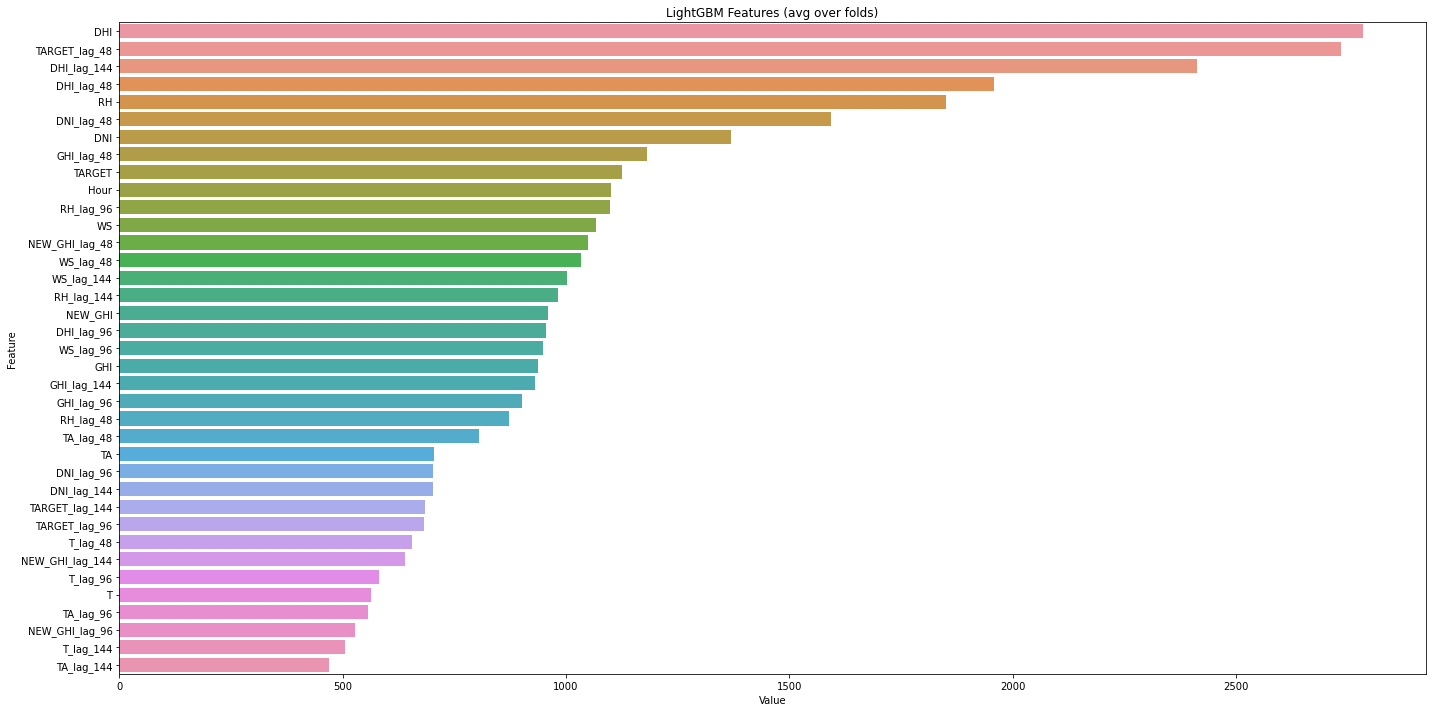

<Figure size 432x288 with 0 Axes>

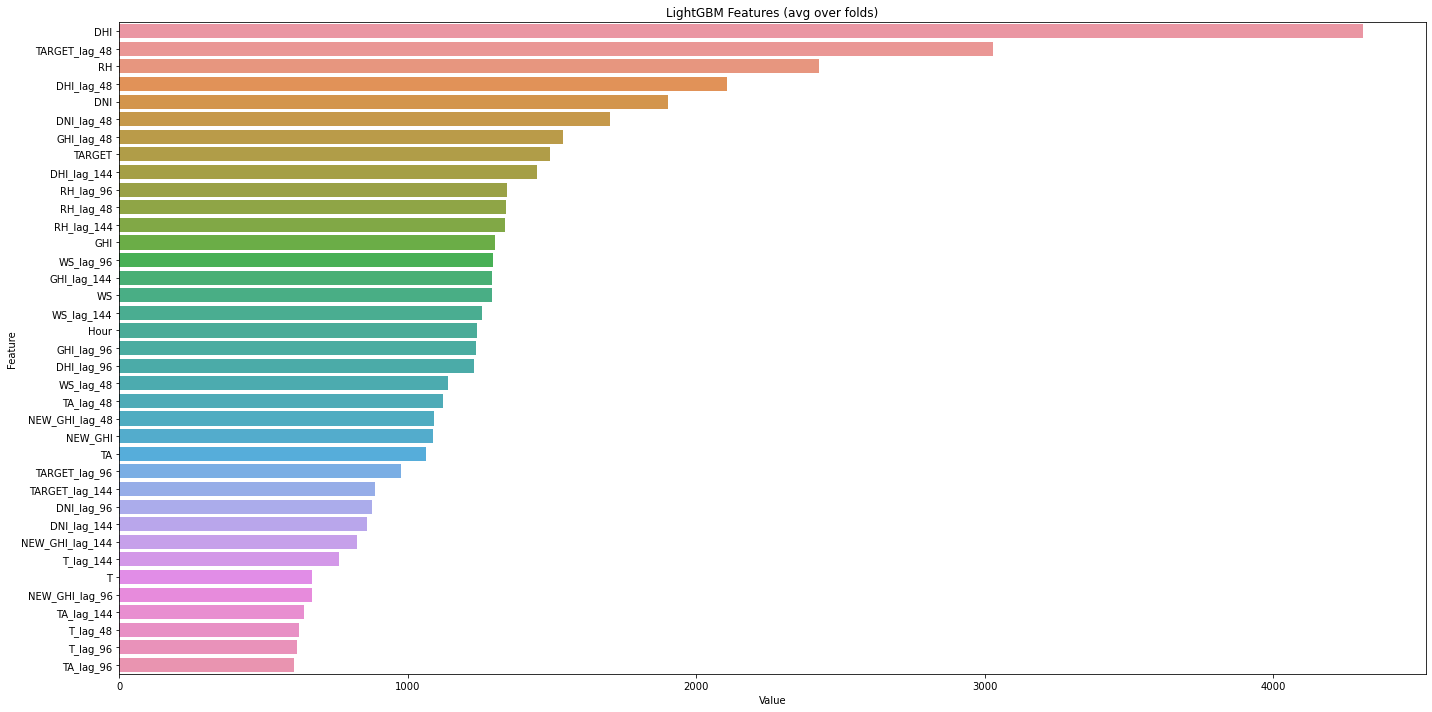

<Figure size 432x288 with 0 Axes>

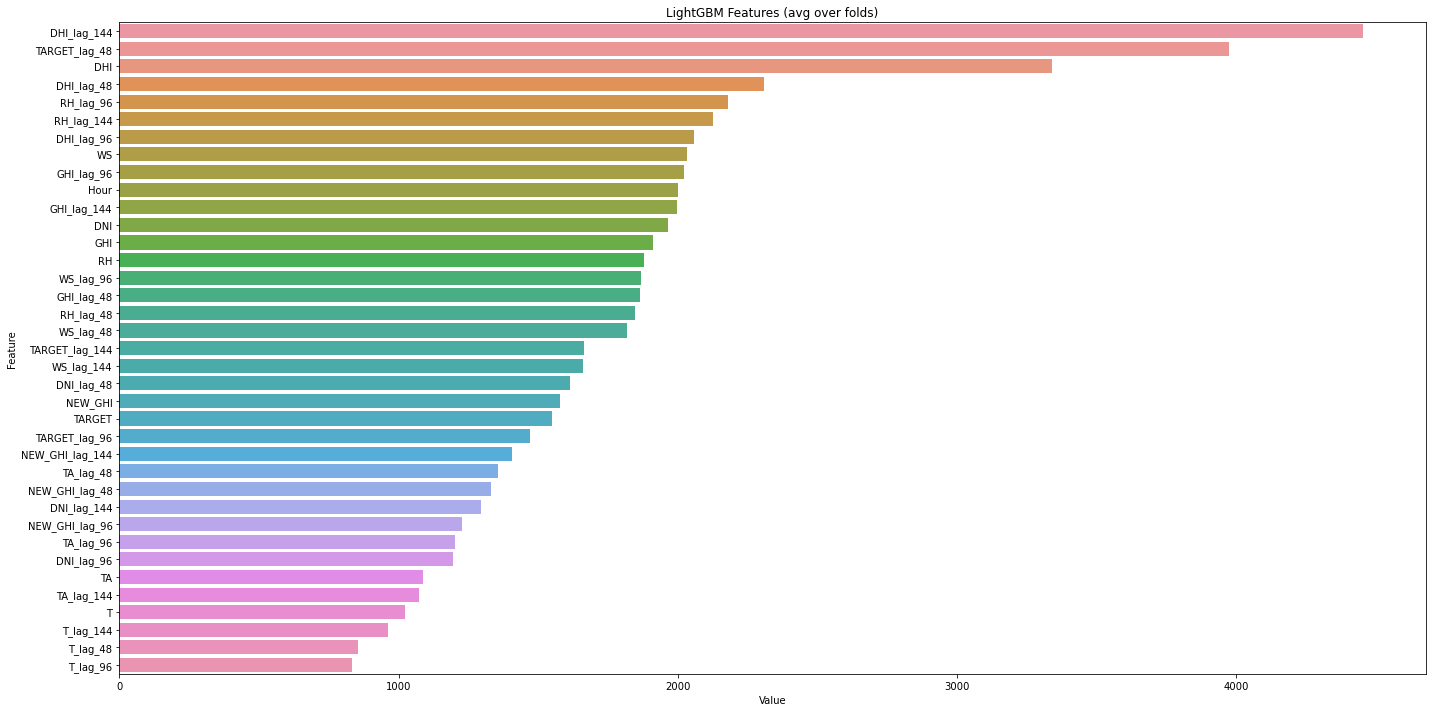

<Figure size 432x288 with 0 Axes>

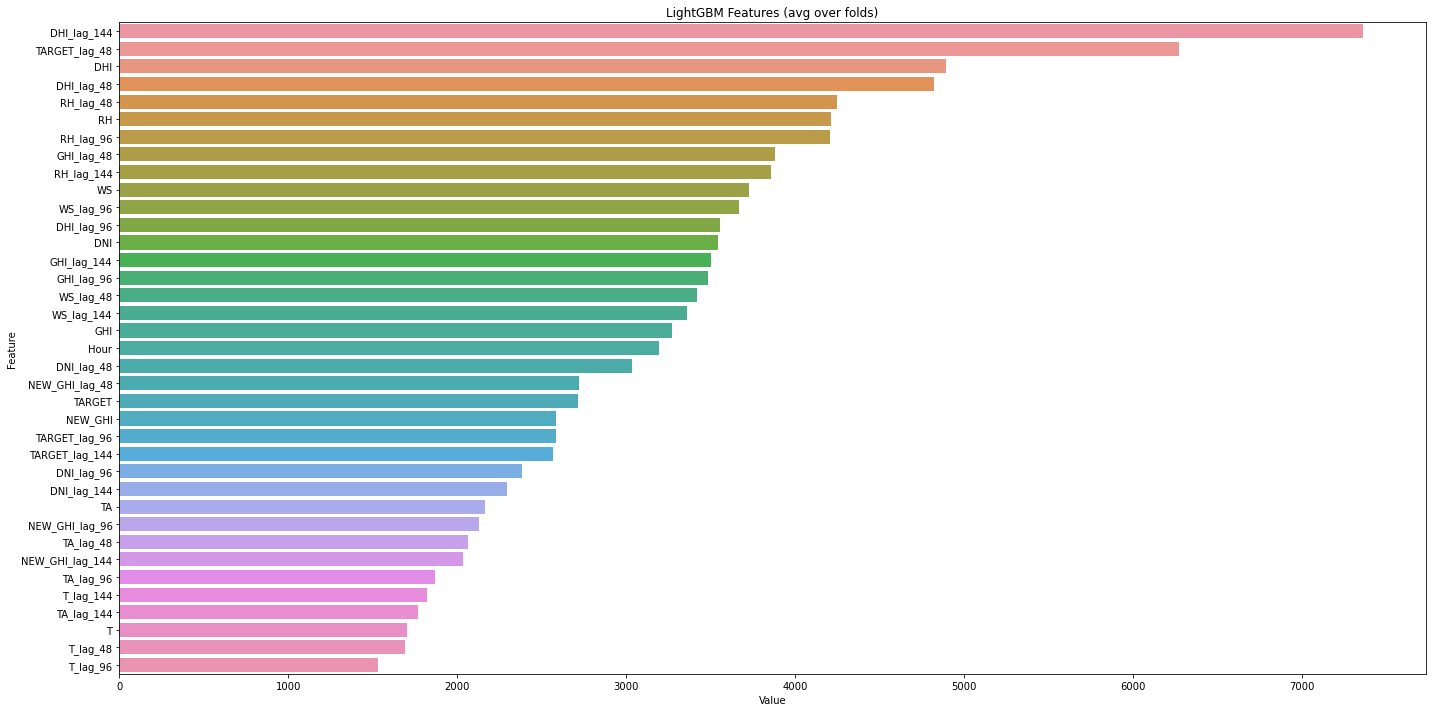

<Figure size 432x288 with 0 Axes>

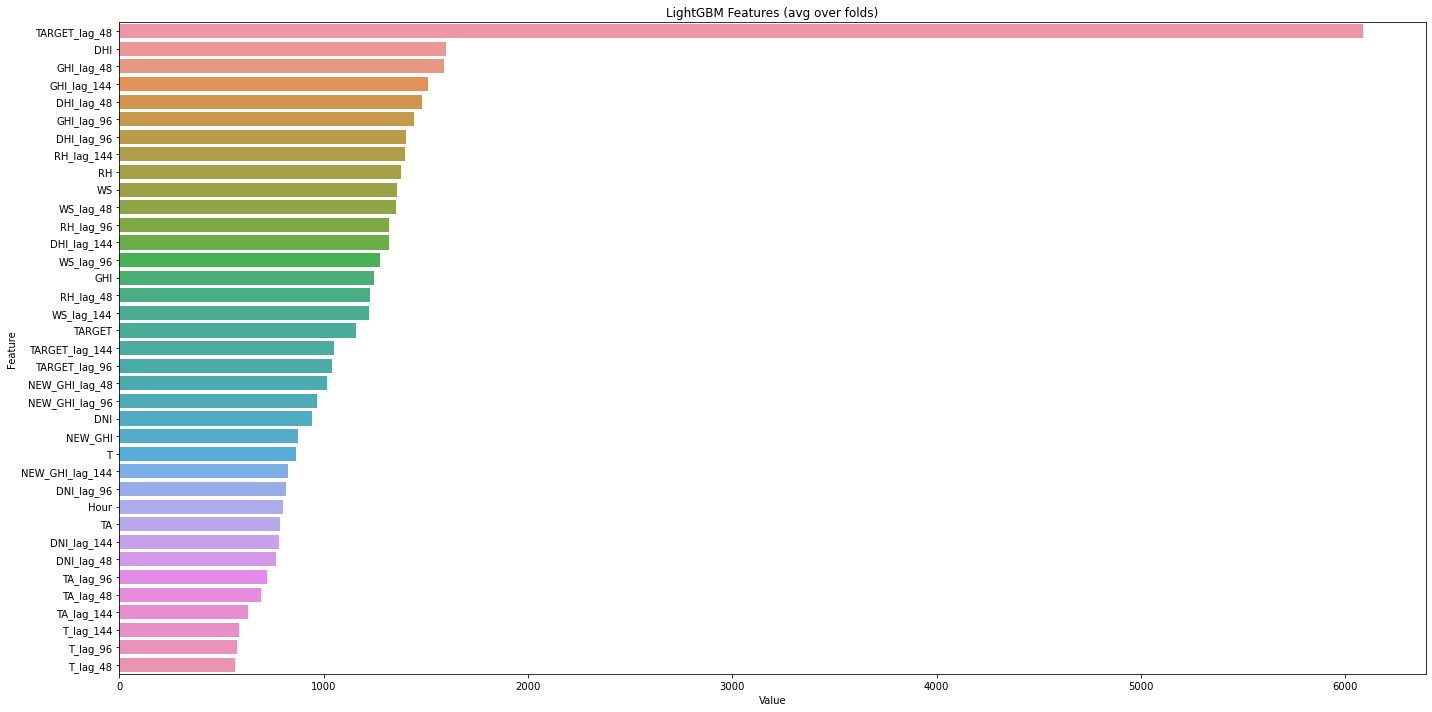

<Figure size 432x288 with 0 Axes>

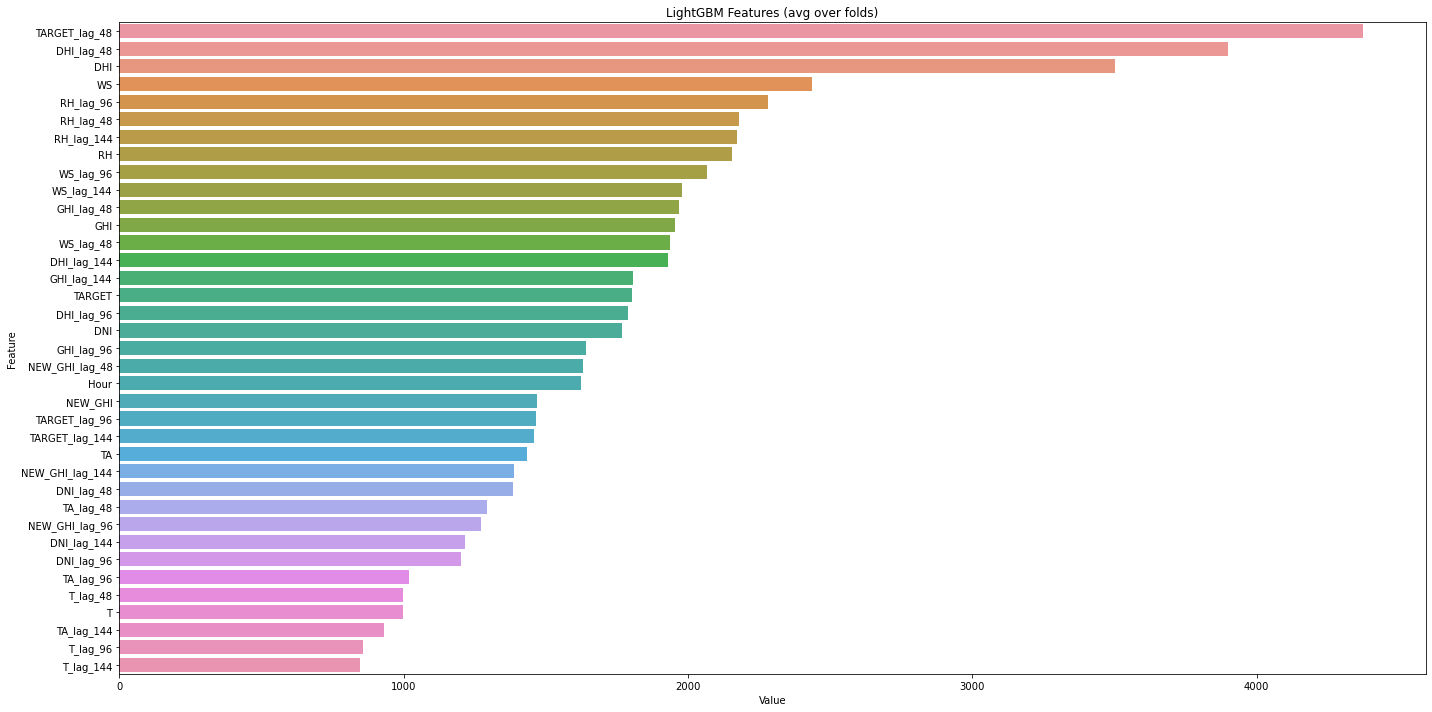

<Figure size 432x288 with 0 Axes>

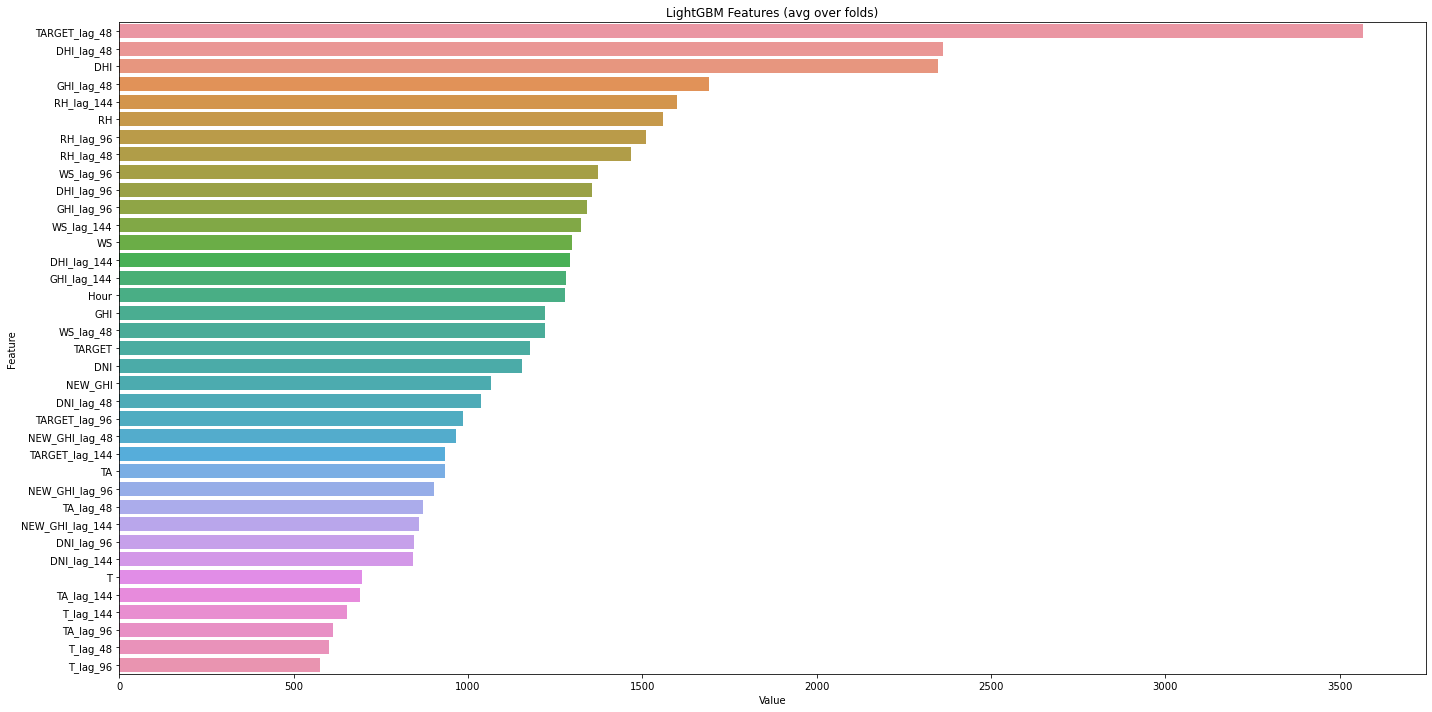

<Figure size 432x288 with 0 Axes>

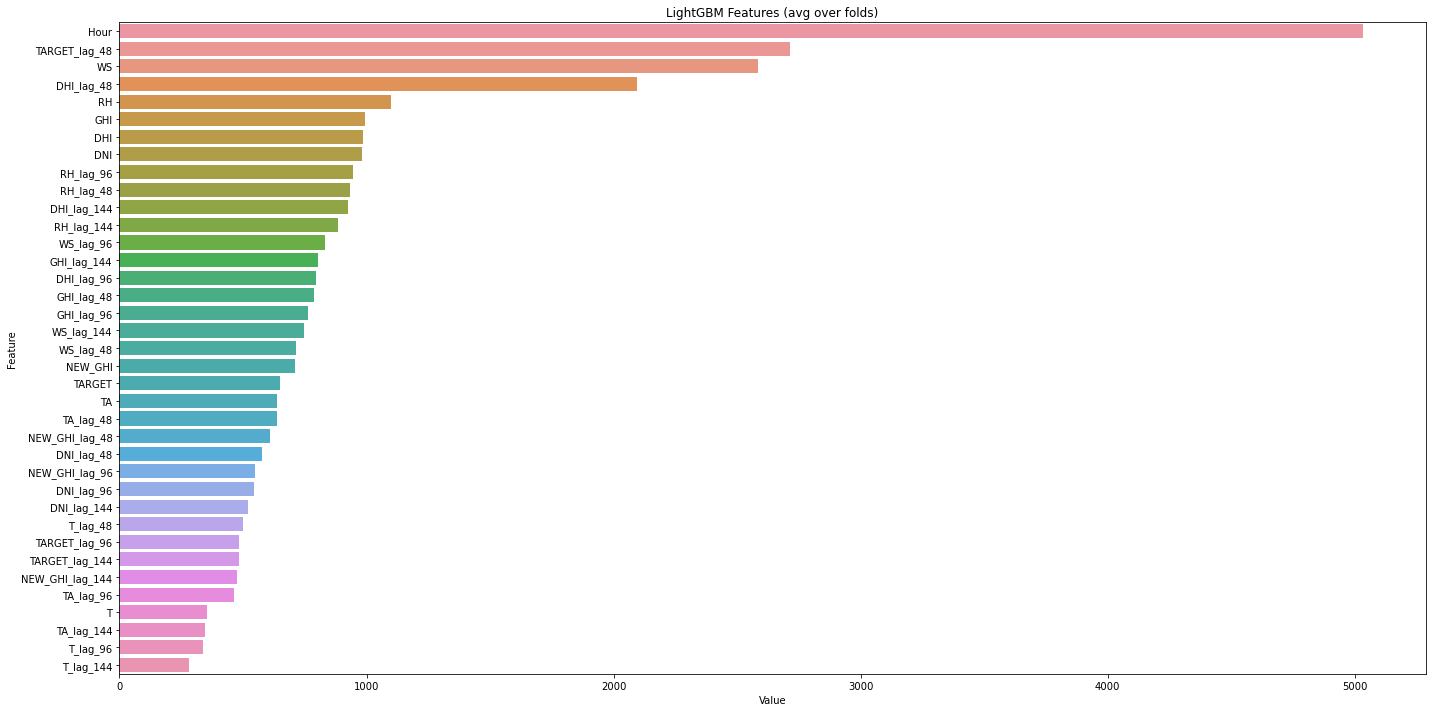

<Figure size 432x288 with 0 Axes>

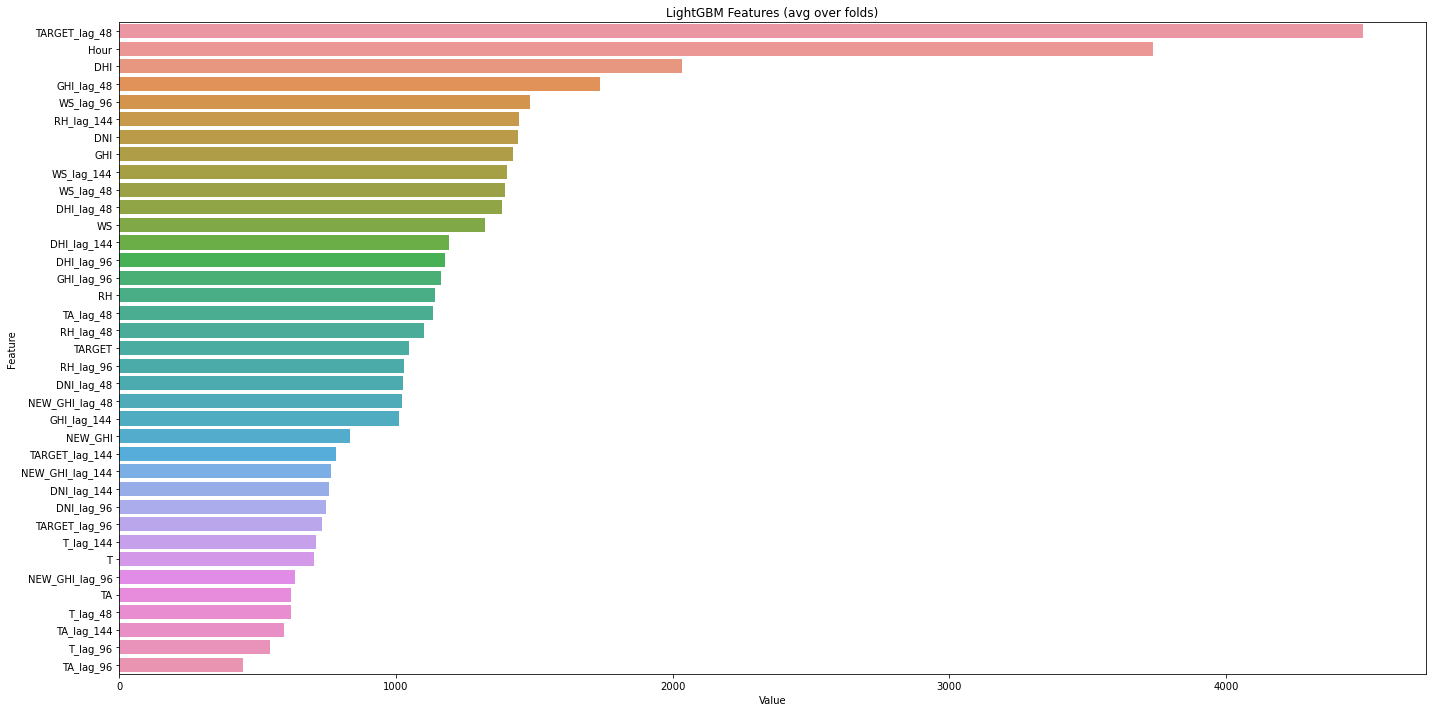

<Figure size 432x288 with 0 Axes>

In [337]:
for i in range(len(models_1)):
    # sorted(zip(clf.feature_importances_, X.columns), reverse=True)
    feature_imp = pd.DataFrame(sorted(zip(models_1[i].feature_importances_,x_train.columns)),
                               columns=['Value','Feature'])

    plt.figure(figsize=(20, 10))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()
    plt.savefig('lgbm_importances-01.png')

In [320]:
# lag model 3 window decross model

submission.loc[submission.id.str.contains("Day7"), "q_0.1":] = results_1.sort_index().values
submission.loc[submission.id.str.contains("Day8"), "q_0.1":] = results_2.sort_index().values
submission[16:33]

#submission.to_csv('./submission/submission_210102_4_2windowDecross.csv', index=False)

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
16,0.csv_Day7_8h00m,3.09,3.29,2.95,3.51,3.57,3.31,3.29,3.27,6.18
17,0.csv_Day7_8h30m,6.44,6.72,6.36,6.24,6.13,6.22,6.29,6.28,6.94
18,0.csv_Day7_9h00m,8.77,8.86,8.75,9.44,9.25,9.11,8.93,8.88,9.63
19,0.csv_Day7_9h30m,16.49,15.91,16.34,15.69,15.87,15.76,15.82,15.93,16.94
20,0.csv_Day7_10h00m,20.15,19.44,19.97,19.90,19.79,20.02,20.02,19.89,20.82
21,0.csv_Day7_10h30m,23.48,23.28,23.07,23.10,23.47,23.54,23.22,23.54,24.77
22,0.csv_Day7_11h00m,26.08,26.54,26.50,26.47,26.14,26.14,26.30,26.32,26.75
23,0.csv_Day7_11h30m,31.24,31.10,30.75,31.36,31.32,30.95,31.26,31.15,31.61
24,0.csv_Day7_12h00m,27.03,28.05,28.06,28.36,28.14,27.81,28.33,28.05,28.14
25,0.csv_Day7_12h30m,32.96,32.90,32.81,32.78,32.71,33.18,33.08,32.93,33.25


3window는 3.0 점대를 기록했습니다.

In [347]:
train.dropna(inplace=True)

In [349]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Hour,52464.0,11.750000,6.926766,0.00,5.875,11.750000,17.625000,23.500000
DHI,52464.0,64.403724,103.955900,0.00,0.000,0.000000,87.000000,528.000000
DNI,52464.0,234.879918,349.702891,0.00,0.000,0.000000,469.000000,1059.000000
WS,52464.0,2.457188,1.427684,0.00,1.400,2.200000,3.200000,12.000000
RH,52464.0,56.764999,22.058516,7.59,39.660,57.560001,72.750000,100.000000
T,52464.0,9.309984,10.163261,-19.00,1.000,9.000000,17.000000,35.000000
TARGET,52464.0,17.807449,25.775522,0.00,0.000,0.000000,32.180977,99.913940
GHI,52464.0,210.506458,292.778655,0.00,0.000,0.000000,401.686115,1149.852257
NEW_GHI,52464.0,250.579797,348.352259,0.00,0.000,0.000000,483.026417,1151.994922
TA,52464.0,299.283642,392.500068,0.00,0.000,0.000000,655.000000,1153.000000


In [394]:
train

,Hour,DHI,DNI,WS,RH,T,TARGET,GHI,NEW_GHI,TA,TARGET_1,TARGET_2
96,0.0,0,0,2.2,73.800003,-8,0.0,0.0,0.0,0,0.0,0.0
97,0.5,0,0,2.1,68.199997,-8,0.0,0.0,0.0,0,0.0,0.0
98,1.0,0,0,2.1,69.059998,-8,0.0,0.0,0.0,0,0.0,0.0
99,1.5,0,0,2.1,69.040001,-8,0.0,0.0,0.0,0,0.0,0.0
100,2.0,0,0,2.2,69.379997,-8,0.0,0.0,0.0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
52555,21.5,0,0,2.4,70.699997,-4,0.0,0.0,0.0,0,0.0,0.0
52556,22.0,0,0,2.4,66.790001,-4,0.0,0.0,0.0,0,0.0,0.0
52557,22.5,0,0,2.2,66.779999,-4,0.0,0.0,0.0,0,0.0,0.0
52558,23.0,0,0,2.1,67.720001,-4,0.0,0.0,0.0,0,0.0,0.0


In [418]:
# 하루 단위로 평균 기온, 분산 기온, 평균 습도, 분산 습도, 평균 풍속, 

def make_AVGVAR(train, start_window=0, window=48):
    
    end_window = train.shape[0] / window
    #stride = window
    RH = train['RH'] # DHI value 값을 받습니다.
    TP = train['T'] # DNI value 값을 받습니다.
    
    RH_AVG = []
    TP_AVG = []
    RH_VAR = []
    TP_VAR = []
    
    #for i in tqdm(range(3)): # 테스트용 코드
    for i in range(np.int(end_window)):
        #print(i)
        if i == 0:
            #print(start_window)
            rh_window = RH[start_window:window] # 0부터 window=48 까지를 슬라이싱 해서 받습니다.
            tp_window = TP[start_window:window]
            # 평균을 뽑아줍니다.
            rh_avg = rh_window.mean()
            tp_avg = tp_window.mean()
            # 분산을 뽑아줍니다.
            rh_var = rh_window.var()
            tp_var = tp_window.var()
            # 리스트로 만들어줍니다.
            rh_avg_list = [rh_avg]*48
            tp_avg_list = [tp_avg]*48
            rh_var_list = [rh_var]*48
            tp_var_list = [tp_var]*48
            
            # 리스트에 더해줍니다.
            RH_AVG = RH_AVG + rh_avg_list
            TP_AVG = TP_AVG + tp_avg_list
            RH_VAR = RH_VAR + rh_var_list
            TP_VAR = TP_VAR + tp_var_list
        else:
            #print(window)
            rh_window = RH[(window*i):(window*(i+1))] # window*i 부터 window*(i+1) 까지를 슬라이싱
            tp_window = TP[(window*i):(window*(i+1))]
            # 평균을 뽑아줍니다.
            rh_avg = rh_window.mean()
            tp_avg = tp_window.mean()
            # 분산을 뽑아줍니다.
            rh_var = rh_window.var()
            tp_var = tp_window.var()
            # 리스트로 만들어줍니다.
            rh_avg_list = [rh_avg]*48
            tp_avg_list = [tp_avg]*48
            rh_var_list = [rh_var]*48
            tp_var_list = [tp_var]*48
            
            # 리스트에 더해줍니다.
            RH_AVG = RH_AVG + rh_avg_list
            TP_AVG = TP_AVG + tp_avg_list
            RH_VAR = RH_VAR + rh_var_list
            TP_VAR = TP_VAR + tp_var_list
            
    train['RH_AVG'] = RH_AVG
    train['TP_AVG'] = TP_AVG
    train['RH_VAR'] = RH_VAR
    train['TP_VAR'] = TP_VAR
    
    return train

In [419]:
new = make_AVGVAR(train)

In [420]:
new

,Hour,DHI,DNI,WS,RH,T,TARGET,GHI,NEW_GHI,TA,TARGET_1,TARGET_2,RH_AVG,TP_AVG,RH_VAR,TP_VAR
96,0.0,0,0,2.2,73.800003,-8,0.0,0.0,0.0,0,0.0,0.0,76.275002,-6.479167,47.676655,17.574025
97,0.5,0,0,2.1,68.199997,-8,0.0,0.0,0.0,0,0.0,0.0,76.275002,-6.479167,47.676655,17.574025
98,1.0,0,0,2.1,69.059998,-8,0.0,0.0,0.0,0,0.0,0.0,76.275002,-6.479167,47.676655,17.574025
99,1.5,0,0,2.1,69.040001,-8,0.0,0.0,0.0,0,0.0,0.0,76.275002,-6.479167,47.676655,17.574025
100,2.0,0,0,2.2,69.379997,-8,0.0,0.0,0.0,0,0.0,0.0,76.275002,-6.479167,47.676655,17.574025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52555,21.5,0,0,2.4,70.699997,-4,0.0,0.0,0.0,0,0.0,0.0,62.066051,-2.708333,160.094528,3.359929
52556,22.0,0,0,2.4,66.790001,-4,0.0,0.0,0.0,0,0.0,0.0,62.066051,-2.708333,160.094528,3.359929
52557,22.5,0,0,2.2,66.779999,-4,0.0,0.0,0.0,0,0.0,0.0,62.066051,-2.708333,160.094528,3.359929
52558,23.0,0,0,2.1,67.720001,-4,0.0,0.0,0.0,0,0.0,0.0,62.066051,-2.708333,160.094528,3.359929


In [421]:
new.describe().T

,count,mean,std,min,25%,50%,75%,max
Hour,52464.0,11.750000,6.926766,0.000000,5.875000,11.750000,17.625000,23.500000
DHI,52464.0,64.403724,103.955900,0.000000,0.000000,0.000000,87.000000,528.000000
DNI,52464.0,234.879918,349.702891,0.000000,0.000000,0.000000,469.000000,1059.000000
WS,52464.0,2.457188,1.427684,0.000000,1.400000,2.200000,3.200000,12.000000
RH,52464.0,56.764999,22.058516,7.590000,39.660000,57.560001,72.750000,100.000000
T,52464.0,9.309984,10.163261,-19.000000,1.000000,9.000000,17.000000,35.000000
TARGET,52464.0,17.807449,25.775522,0.000000,0.000000,0.000000,32.180977,99.913940
GHI,52464.0,210.506458,292.778655,0.000000,0.000000,0.000000,401.686115,1149.852257
NEW_GHI,52464.0,250.579797,348.352259,0.000000,0.000000,0.000000,483.026417,1151.994922
TA,52464.0,299.283642,392.500068,0.000000,0.000000,0.000000,655.000000,1153.000000
